### Install and Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.affinity import rotate, scale, translate
from datetime import datetime
import math

### Load and Preprocess Input Data

In [16]:
# Load the data
df = pd.read_csv('example.csv')
df = df[['MMSI','LAT','LON','TIMESTAMP UTC']]
df['ConvBaseDateTime'] = df['TIMESTAMP UTC'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
df = df.groupby('MMSI').apply(lambda x: x.sort_values(by='ConvBaseDateTime')).reset_index(drop=True)
df['time_difference'] = df.groupby('MMSI')['ConvBaseDateTime'].diff().dt.total_seconds()
df['previous_lat'] = df.groupby('MMSI')['LAT'].shift(1)
df['previous_lon'] = df.groupby('MMSI')['LON'].shift(1)
df['segment'] = df.apply(lambda row: [(row['previous_lat'], row['previous_lon']), (row['LAT'], row['LON'])], axis=1)
df.dropna(subset=['previous_lat', 'previous_lon', 'time_difference'], inplace=True)
# Extract segments where time_difference is greater than 30 mins
segments = df[df['time_difference'] > 1800]
segments = segments[['MMSI','segment','ConvBaseDateTime','time_difference']]

### Filter out anomalous trajectory from Galapagos Case Study 

In [17]:
mmsi_segment = segments.loc[df['MMSI'] == 352419000]
sorted_mmsi_segment = mmsi_segment.sort_values(by='time_difference', ascending=False)
start_point = sorted_mmsi_segment.head(1)['segment'].tolist()[0][0]
end_point = sorted_mmsi_segment.head(1)['segment'].tolist()[0][1]
time_difference = sorted_mmsi_segment.head(1)['time_difference'].tolist()[0]

### Modelling geo-ellipse from start and end point of trajectory gap

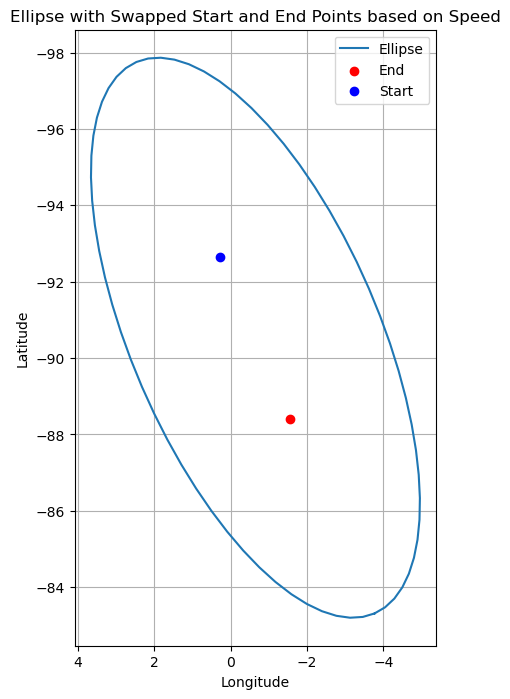

In [37]:
def create_geoellipse(midpoint, major_axis_length, minor_axis_length, angle):
    circle = Point(0, 0).buffer(1)
    ellipse = scale(circle, xfact=major_axis_length, yfact=minor_axis_length)
    ellipse = rotate(ellipse, angle, origin=(0,0))
    ellipse = translate(ellipse, xoff=midpoint[0], yoff=midpoint[1])
    return ellipse

def plot_ellipse_with_speed(start_coords, end_coords, speed, time_duration):
    dy = end_coords[1] - start_coords[1]
    dx = end_coords[0] - start_coords[0]
    distance = np.sqrt(dx**2 + dy**2)
    angle_rad = math.atan2(dy, dx)
    angle = math.degrees(angle_rad)
    
    # Compute potential distance traveled in degrees
    potential_distance_traveled = speed * time_duration / 111320.0  # Convert from meters to degrees

    major_axis_length = distance + 2 * potential_distance_traveled
    minor_axis_length = 2 * potential_distance_traveled

    midpoint = ((start_coords[0] + end_coords[0]) / 2, (start_coords[1] + end_coords[1]) / 2)

    geoellipse = create_geoellipse(midpoint, major_axis_length, minor_axis_length, angle)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal', 'box')
    x, y = geoellipse.exterior.xy
    ax.plot(x, y, label="Ellipse")
    
    # Swap the coordinates before plotting
    ax.scatter(*end_coords, color='red', label="End")
    ax.scatter(*start_coords, color='blue', label="Start")
    
    # Invert the x and y axis values
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.grid(True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Ellipse with Swapped Start and End Points based on Speed')
    plt.show()
    
    return geoellipse

speed = 0.141 # 10 m/s

geoellipse_new = plot_ellipse_with_speed(start_point, end_point, speed, time_difference)

### Compute Binary Raster Map for Signal Coverage 

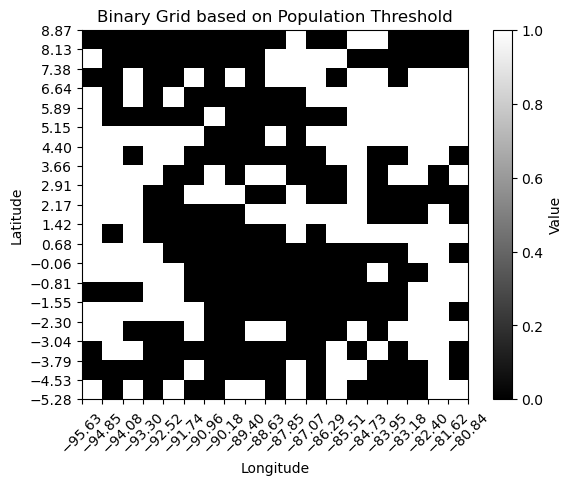

In [38]:
# Load the data
df = pd.read_csv('example.csv')
df = df[['MMSI','LAT','LON','TIMESTAMP UTC']]

# Drop rows with NaN values in 'LAT' and 'LON' columns
df.dropna(subset=['LAT', 'LON'], inplace=True)

# 1. Define grid resolution
lat_bins = np.linspace(df['LAT'].min(), df['LAT'].max(), num=20)
lon_bins = np.linspace(df['LON'].min(), df['LON'].max(), num=20)

# 2. Assign each point to a grid cell
df['LAT_bin'] = pd.cut(df['LAT'], bins=lat_bins, labels=False, include_lowest=True)
df['LON_bin'] = pd.cut(df['LON'], bins=lon_bins, labels=False, include_lowest=True)

# 3. Count points in each grid cell
grid_counts = df.groupby(['LAT_bin', 'LON_bin']).size().reset_index(name='count')

# 4. Create an empty grid
grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1), dtype=int)

# 5. Populate the grid with count values
for _, row in grid_counts.iterrows():
    grid[int(row['LAT_bin']), int(row['LON_bin'])] = row['count']

# 6. Convert grid to binary based on some threshold
population_threshold = 10  # for example
binary_grid = (grid > population_threshold).astype(int)

# 7. Visualize the binary grid as a raster
plt.imshow(binary_grid, cmap='gray', origin='lower', extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]])
plt.colorbar(label='Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Binary Grid based on Population Threshold')
plt.xticks(lon_bins, rotation=45)
plt.yticks(lat_bins)
plt.show()

### Compute AGM Score for the geo-ellipse

In [40]:
def cell_inside_ellipse(cell_center, cell_size, ellipse):
    """
    Check if any part of a grid cell is inside or on the ellipse.
    cell_center: tuple of (lat, lon) of the center of the grid cell.
    cell_size: tuple of (lat_delta, lon_delta) indicating the size of the grid cell.
    ellipse: shapely.geometry.Polygon representing the ellipse.
    """
    lat, lon = cell_center
    lat_delta, lon_delta = cell_size
    
    # Define the four corners of the grid cell
    corners = [(lat - lat_delta/2, lon - lon_delta/2),
               (lat - lat_delta/2, lon + lon_delta/2),
               (lat + lat_delta/2, lon - lon_delta/2),
               (lat + lat_delta/2, lon + lon_delta/2)]
    
    # Check if any corner of the cell is inside or on the ellipse
    for corner in corners:
        if ellipse.intersects(Point(corner)):
            return True
    return False

# Compute the size of the grid cell
lat_size = lat_bins[1] - lat_bins[0]
lon_size = lon_bins[1] - lon_bins[0]
cell_size = (lat_size, lon_size)

# Checking each grid cell
inside_ellipse = 0
value_of_one = 0
for i in range(binary_grid.shape[0]):
    for j in range(binary_grid.shape[1]):
        cell_center = (lat_bins[i] + lat_size/2, lon_bins[j] + lon_size/2)
        if cell_inside_ellipse(cell_center, cell_size, geoellipse_new):
            inside_ellipse += 1
            if binary_grid[i, j] == 1:
                value_of_one += 1

ratio = value_of_one / inside_ellipse if inside_ellipse != 0 else 0

print(f"Number of cells inside ellipse: {inside_ellipse}")
print(f"Number of cells inside ellipse with a value of 1: {value_of_one}")
print(f"AGM Score (Ratio): {ratio}")

Number of cells inside ellipse: 147
Number of cells inside ellipse with a value of 1: 54
AGM Score (Ratio): 0.3673469387755102
